In [1]:
import sympy as sp
from functions import *
import numpy as np
from sympy.matrices import matrix_multiply_elementwise
import matplotlib.pyplot as plt 
#sp.init_printing(use_latex="mathjax")
import matplotlib
from numerical import P_num_over_E_single as P_num
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

m_21, m_31, m_41 = sp.symbols("dm_21 dm_31 dm_41", real = True, constant=True)
th_12, th_13,th_23,th_34,th_23,th_14, th_24 = sp.symbols('theta_12 theta_13 theta_23 theta_34 theta_23 theta_14 theta_24', real = True, constant=True)
E = sp.symbols('E', real = True, constant=True)
d_ij=sp.symbols('delta_ij')
V_cc, V_nc,= sp.symbols("V_cc,V_nc", real = True, constant=True)
A_cc, A_nc,= sp.symbols("A_cc,A_nc", real = True, constant=True)
param_dict_num =param_dict # Regular dict with parameter values
param_dict_sym = {'theta_12': th_12, # Symbolic dict with sympy symbols
                'theta_13': th_13,
                'theta_23': th_23,
                'theta_34': th_34,
                'theta_24': th_24,
                'theta_14': th_14,
                'delta_ij': d_ij,
                'dm_21': m_21,
                'dm_31': m_31,
                'dm_41': m_41}

def V_ijab(i,j,a,b,params=param_dict_sym): # Blennow 78:807 delta_ij = 0
    if a == b:
        if a == i or a == j:
            return sp.cos(theta(i,j,0, params=params))
        else:
            return 1
    else:
        if a == i and b == j:
            return sp.sin(-theta(i,j,0, params=params)) 
        elif a == j and b == i:
            return -sp.sin(-theta(i,j,0, params=params))
        else:
            return 0


def V_matrix(i,j, n = 0, params=param_dict_sym): # Blennow 78:807
    result = sp.zeros(3+n,3 + n)
    for a in range(1, 4+n):
        elem1 = [V_ijab(i,j,a,b, params=params) for b in range(1, 3 + n + 1)]
        result[a-1] = elem1
    return result

def U_nu(ndim,params=param_dict_sym, mtype='full'):
    if mtype == 'single':
        return V_matrix(3,4,1, params=params) @ V_matrix(2,4,1, params=params) @ V_matrix(1,4,1, params=params)
    else:
        return V_matrix(3,4,1, params=params) @ V_matrix(2,4,1, params=params) @ V_matrix(1,4,1, params=params) @ V_matrix(2,3,1, params=params) @ V_matrix(1,3,1, params=params)
def get_H_(En,params,mtype, anti, V=None):
    '''
    En in [GeV]
    '''
    if mtype == 'full':
        U = U_nu(4, params=params)
    elif mtype == 'single':
        U = V_matrix(3,4,1, params=params) @ V_matrix(2,4,1, params=params) @ V_matrix(1,4,1, params=params)
    if anti:
        #A = -sp.diag(2*E*V_cc, 0 , 0, 2*E*V_nc)
        M = sp.diag(0,params['dm_21'],params['dm_31'],-params['dm_41'])
    else:
        M = sp.diag(0,params['dm_21'],params['dm_31'],params['dm_41'])
    if V is not None:
        A = sp.diag(2*E*V, 0 , 0, E*V)
    else:
        A = sp.diag(2*E*V_cc, 0 , 0, E*V_nc)
    H = 1/(2*E*1e9) * (U @ M @ U.T + A*1e18)
    H = H.subs(E,En)
    return H

def diagonalize_H_(H,anti):
    #TODO: clean up
    UM_unsorted, HM_unsorted = H.diagonalize(reals_only=False,sort=True, normalize=True) 
    HM_unsorted = np.diag(np.asarray(HM_unsorted))
    UM_unsorted = np.asarray(UM_unsorted)
    if anti:
        UM_sorted = np.array([UM_unsorted[:,0], UM_unsorted[:,2], UM_unsorted[:,1], UM_unsorted[:,3]])
        HM_sorted = np.array([HM_unsorted[0], HM_unsorted[1], HM_unsorted[2], HM_unsorted[3]])
    else:
        UM_sorted = np.array([UM_unsorted[:,1], UM_unsorted[:,2], UM_unsorted[:,3], UM_unsorted[:,0]])
        HM_sorted = np.array([HM_unsorted[1], HM_unsorted[2], HM_unsorted[3], HM_unsorted[0]])
    return UM_sorted, HM_sorted

    
def get_dmM_(HM, En):
    '''
    En in [GeV]
    '''
    eigenvals = HM * np.array([1,1,1,1])
    dmM_res = 2 * En * 1e9 * eigenvals
    return dmM_res


def get_dmM(En, params, mtype, anti):
    '''
    En in [GeV]
    '''
    H = get_H_(En, params=params, mtype=mtype, anti=anti)
    UM,HM= diagonalize_H_(H,anti)
    dmM = get_dmM_(HM, En)
    return dmM

V_cc = np.sqrt(2) * GF * 0.5 * N_A * 8.44 * (1/GeVtocm1)**3 #GeV
V_nc = V_cc / 2 #GeV

In [2]:
symb_params_simple = param_dict_sym.copy()
symb_params = param_dict_sym.copy()

symb_params.update({'theta_12': param_dict_num['theta_12'],
                       'theta_13': param_dict_num['theta_13'],
                       'theta_23': param_dict_num['theta_23'],
                       'theta_14': 0,
                       'theta_24': param_dict_sym['theta_24'],
                       'theta_34': param_dict_sym['theta_34'],
                       'dm_21': 0,
                       'dm_31': 0,
                       'dm_41': param_dict_num['dm_41']
                       })

symb_params_simple.update({'theta_12': 1,
                       'theta_13': 1,
                       'theta_23': 1,
                       'theta_14': 0,
                       'theta_24': param_dict_sym['theta_24'],
                       'theta_34': param_dict_sym['theta_34'],
                       'dm_21': 0,
                       'dm_31': 0,
                       'dm_41': param_dict_num['dm_41']
                       })

In [5]:
#UM_list = []
#for V in [1e-13,2e-13,3e-13]:
for E in [3e3]:#,2e3,3e3]:
    H=get_H_(E,symb_params,mtype='single', anti=True, V = 1e-13)
    UM, HM = H.diagonalize(reals_only=False,sort=True, normalize=True)
    UM[:,0],UM[:,1] = UM[:,1],UM[:,0]
    UM[:,1],UM[:,2] = UM[:,2],UM[:,1]
    UM_a1 = UM[:,1]
    UM_a4 = UM[:,3]

    UM_e4 = UM_a4[0]
    UM_m4 = UM_a4[1]
    UM_t4 = UM_a4[2]
    UM_s4 = UM_a4[3]

    UM_list.append(UM_t4)

In [131]:
ex1 = UM_list[0]
UM_with_constants= ex1
const_dict={}
const = sp.numbered_symbols("C", cls=sp.Dummy)
for a in sp.preorder_traversal(ex1):
    if isinstance(a, sp.Float) and a != 1 and a != 0.5:
        c = next(const)
        const_dict[c] = a
        UM_with_constants = ex2.subs(a, c)

In [157]:
replacements =[]
formulas = []
for UM_t4 in [UM_with_constants]:
    replacement, UM_t4_formula = sp.cse(UM_t4)
    UM_t4_formula = UM_t4_formula[0]
    x = np.array(replacement)[:,1]
    replacements.append(replacement)
    formulas.append(UM_t4_formula)


In [158]:
replacements[0]

[(x0, sin(theta_34)),
 (x1, cos(theta_34)),
 (x2, cos(theta_24)),
 (x3, x2**2),
 (x4, x1**2),
 (x5, x3*x4),
 (x6, (_C1*x5 + 1)**0.5),
 (x7, _C28*x6),
 (x8, _C3*x6),
 (x9, x6 + 1),
 (x10, x2**4),
 (x11, x10*x4),
 (x12, _C5*x5),
 (x13, _C7*x3)]

In [159]:
formulas[0]

x0*x1*x3*(_C30 + x7)/(sqrt(_C0*x5*(_C2*x3 + x12 + x3*x8 + x9)**2*sin(theta_24)**2/(_C12*x11 + _C15*x11*x6 + _C8*x1**4*x10 + _C9*x5 + x12*x6 + x13*x6 + x13 + x9)**2 + _C17*x0**2*x11*(_C18*x6 + 1)**2/(_C21*x5 + x5*x8 + x9)**2 + 1.0)*(_C24*x6 + _C24 + _C27*x5 + x5*x7))

In [172]:
const_dict

{_C0: 1.11111111851852e-17,
 _C1: 1.33333334222222e-8,
 _C2: 3.33333335555556e-9,
 _C3: 3.33333333333333e-9,
 _C4: 1.33333334222222e-8,
 _C5: 6.66666668888889e-9,
 _C6: 1.33333334222222e-8,
 _C7: 3.33333334444444e-9,
 _C8: 2.22222223703704e-17,
 _C9: 1.33333334000000e-8,
 _C10: 3.33333334444444e-9,
 _C11: 1.33333334222222e-8,
 _C12: 3.33333335925926e-17,
 _C13: 6.66666668888889e-9,
 _C14: 1.33333334222222e-8,
 _C15: 1.11111111481481e-17,
 _C16: 1.33333334222222e-8,
 _C17: 1.11111112592593e-17,
 _C18: 0.999999993333333,
 _C19: 1.33333334222222e-8,
 _C20: 1.33333334222222e-8,
 _C21: 1.00000000444444e-8,
 _C22: 3.33333333333333e-9,
 _C23: 1.33333334222222e-8,
 _C24: 8.99999997000000e+16,
 _C25: 8.99999997000000e+16,
 _C26: 1.33333334222222e-8,
 _C27: 900000001.000000,
 _C28: 299999999.000000,
 _C29: 1.33333334222222e-8,
 _C30: 300000001.000000,
 _C31: 299999999.000000,
 _C32: 1.33333334222222e-8}

In [160]:
def dm_func(E,V,theta24,theta34,a):
    return np.sqrt(np.cos(theta24)**2*np.cos(theta34)**2/(a*E*V) + 1)
def func(E,V,theta24,theta34,a,b,c,d,f):
    dm = dm_func(E,V,theta24,theta34,a)
    s34 = np.sin(theta34)
    s24 = np.sin(theta24)
    return b*dm*s34/(np.sqrt(c*s24**2*dm + s34**2*(d*dm+1)**2/(e*dm**4) + 1)* f*dm**2)

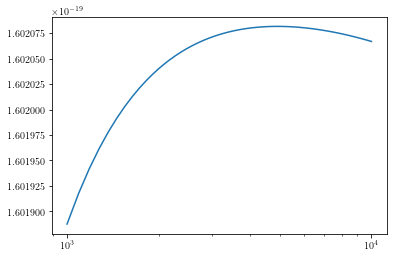

In [163]:
E=3e3
V = 1e-13
theta24 = 0.1
theta34 = 0.05
U = [func(En,V,0.04,0.04,1,1,1,1,1)**2 for En in np.linspace(1e3,1e4,100)]
#U1 = [func(En,V,0.04,0.02,1,1,1,1,1) for En in np.linspace(1e3,1e4,100)]
plt.plot(np.linspace(1e3,1e4,100),U)
#plt.plot(np.linspace(1e3,1e4,100),U1)
plt.xscale('log')

In [150]:
UM_list[0].subs({th_24:0.1, th_34:0.02})

6.59846198621752e-11